In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sqlalchemy
from sqlalchemy import create_engine # database connection
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, clear_output
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
# engine  = create_engine("sqlite:///../input/database.sqlite")
with sqlite3.connect('database.sqlite') as engine:
#    matches = pd.read_sql_query('SELECT * FROM Match where league_id = 1729 and season in ("2010/2011", "2011/2012", "2012/2013", "2013/2014", "2014/2015", "2015/2016");'
#                                          , engine)
    matches = pd.read_sql_query('SELECT * FROM Match where league_id = 1729 ;', engine)


matches = matches[matches.columns[:11]]
teams = pd.read_sql_query('SELECT * FROM Team;', engine)

# Add team names & tidy up
matches = pd.merge(left=matches, right=teams, how='left', left_on='home_team_api_id', right_on='team_api_id')
matches = matches.drop(['country_id','league_id', 'home_team_api_id', 'id_y', 'team_api_id', 'team_short_name'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'home_team'}, inplace=True)
matches = pd.merge(left=matches, right=teams, how='left', left_on='away_team_api_id', right_on='team_api_id')
matches = matches.drop(['id', 'match_api_id', 'away_team_api_id','team_api_id', 'team_short_name'], axis=1)
matches.rename(columns={'id_x':'match_id', 'team_long_name':'away_team'}, inplace=True)

matches.tail(20)
# matches.info()

,match_id,season,stage,date,home_team_goal,away_team_goal,team_fifa_api_id_x,home_team,team_fifa_api_id_y,away_team
3020,4749,2015/2016,8,2015-10-04 00:00:00,3,0,1.0,Arsenal,11.0,Manchester United
3021,4750,2015/2016,8,2015-10-03 00:00:00,0,1,2.0,Aston Villa,1806.0,Stoke City
3022,4751,2015/2016,8,2015-10-03 00:00:00,1,1,1943.0,Bournemouth,1795.0,Watford
3023,4752,2015/2016,8,2015-10-03 00:00:00,1,3,5.0,Chelsea,17.0,Southampton
3024,4753,2015/2016,8,2015-10-03 00:00:00,2,0,1799.0,Crystal Palace,109.0,West Bromwich Albion
3025,4754,2015/2016,8,2015-10-04 00:00:00,1,1,7.0,Everton,9.0,Liverpool
3026,4755,2015/2016,8,2015-10-03 00:00:00,6,1,10.0,Manchester City,13.0,Newcastle United
3027,4756,2015/2016,8,2015-10-03 00:00:00,1,2,1792.0,Norwich City,95.0,Leicester City
3028,4757,2015/2016,8,2015-10-03 00:00:00,2,2,106.0,Sunderland,19.0,West Ham United
3029,4758,2015/2016,8,2015-10-04 00:00:00,2,2,1960.0,Swansea City,18.0,Tottenham Hotspur


In [3]:
def convert_date_to_code16(matches_data_16):
    date = []
    for i in matches_data_16['date']:
        date.append(i)
    x = date[0]
    d = datetime.strptime(x, "%d/%m/%y").date()
    dict2 = {}
    base = 42595
    for i in date:
        date_l = datetime.strptime(i, "%d/%m/%y").date()
        date_dif = date_l - d
        dict2[date_l] = str(base + date_dif.days)
    t = []
    for i in range(len(date)):
        t.append(dict2[datetime.strptime(date[i], '%d/%m/%y').date()])
    matches_data_16['date'] = list(map((lambda i: t[i]), range(len(t))))
    return matches_data_16

# def convert_date_to_code17(matches_data):
#     date = []
#     for i in matches_data['date']:
#         date.append(i)
#     x = date[0]
#     d = datetime.strptime(x, "%d/%m/%y").date()
#     dict2 = {}
#     base = 42959
#     for i in date:
#         date_l = datetime.strptime(i, "%d/%m/%y").date()
#         date_dif = date_l - d
#         dict2[date_l] = str(base + date_dif.days)
#     t = []
#     for i in range(len(date)):
#         t.append(dict2[datetime.strptime(date[i], '%d/%m/%y').date()])
#     matches_data['date'] = list(map((lambda i: t[i]), range(len(t))))
#     return matches_data

def convert_date_to_code17(matches_data_17):
    stage = []
    for i in matches_data_17['stage']:
        stage.append(i)
    date = []
    for i in matches_data_17['date']:
        date.append(i)
    dict_date = {}
    for i, j in zip(stage, date):
        dict_date[i] = datetime.strptime(j, "%d/%m/%y").date()
    dict2 = {}
    base = 42959
    for i in stage:
        if i == 1:
            dict2[i] = base
        else:
            date_dif = dict_date[i] - dict_date[i - 1]
            if date_dif.days < 13:
                dict2[i] = dict2[i - 1] + 7
            if date_dif.days >= 13:
                dict2[i] = dict2[i - 1] + 14
    t = []
    for i in stage:
        t.append(str(dict2[i]))
    matches_data_17['date'] = list(map((lambda i: t[i]), range(len(t))))
    return matches_data_17

In [4]:
def convert_team_name(last_season):
    for index, row in last_season.iterrows():
        if row['home_team'] == 'Man United':
            last_season.loc[index, 'home_team'] = 'Manchester United'
        if row['home_team'] == 'Man City':
            last_season.loc[index, 'home_team'] = 'Manchester City'
        if row['home_team'] == 'Leicester':
            last_season.loc[index, 'home_team'] = 'Leicester City'
        if row['home_team'] == 'West Brom':
            last_season.loc[index, 'home_team'] = 'West Bromwich Albion'
        if row['home_team'] == 'Newcastle':
            last_season.loc[index, 'home_team'] = 'Newcastle United'
        if row['home_team'] == 'Stoke':
            last_season.loc[index, 'home_team'] = 'Stoke City'
        if row['home_team'] == 'Swansea':
            last_season.loc[index, 'home_team'] = 'Swansea City'
        if row['home_team'] == 'West Ham':
            last_season.loc[index, 'home_team'] = 'West Ham United'
        if row['home_team'] == 'Tottenham':
            last_season.loc[index, 'home_team'] = 'Tottenham Hotspur'
        if row['home_team'] == 'Hull':
            last_season.loc[index, 'home_team'] = 'Hull City'
        if row['home_team'] == 'Brighton & Hove Albion':
            last_season.loc[index, 'home_team'] = 'Brighton'
        if row['home_team'] == 'Huddersfield Town':
            last_season.loc[index, 'home_team'] = 'Huddersfield'

        if row['away_team'] == 'Man United':
            last_season.loc[index, 'away_team'] = 'Manchester United'
        if row['away_team'] == 'Man City':
            last_season.loc[index, 'away_team'] = 'Manchester City'
        if row['away_team'] == 'Leicester':
            last_season.loc[index, 'away_team'] = 'Leicester City'
        if row['away_team'] == 'West Brom':
            last_season.loc[index, 'away_team'] = 'West Bromwich Albion'
        if row['away_team'] == 'Newcastle':
            last_season.loc[index, 'away_team'] = 'Newcastle United'
        if row['away_team'] == 'Stoke':
            last_season.loc[index, 'away_team'] = 'Stoke City'
        if row['away_team'] == 'Swansea':
            last_season.loc[index, 'away_team'] = 'Swansea City'
        if row['away_team'] == 'West Ham':
            last_season.loc[index, 'away_team'] = 'West Ham United'
        if row['away_team'] == 'Tottenham':
            last_season.loc[index, 'away_team'] = 'Tottenham Hotspur'
        if row['away_team'] == 'Hull':
            last_season.loc[index, 'away_team'] = 'Hull City'
        if row['away_team'] == 'Brighton & Hove Albion':
            last_season.loc[index, 'away_team'] = 'Brighton'
        if row['away_team'] == 'Huddersfield Town':
            last_season.loc[index, 'away_team'] = 'Huddersfield'
    return last_season

In [5]:
def create_match_id():
    match_id_num = []
    match_id_num2 = []
    for i in range(1, 11):
        match_id_num.append(i)
    for i in match_id_num:
        match_id_num2.append(i + int(last_season[-1:]['match_id']))
    return match_id_num2

In [6]:
with sqlite3.connect('database2.sqlite') as con:
    matches_data_16 = pd.read_sql('select * from match;', con)
    matches_data_17 = pd.read_sql('select * from match17;', con)
    matches_schedule = pd.read_sql('select * from match_schedule3;', con)
# matches_data_16['date'] = pd.to_datetime(matches_data_16['date'])

matches_data_16 = convert_date_to_code16(matches_data_16)
matches_data_17 = convert_date_to_code17(matches_data_17)
matches_schedule = convert_date_to_code17(matches_schedule)
last_season = pd.concat([matches_data_16, matches_data_17])
# last_season.tail()
# int(last_season[-1:]['match_id'])
# matches_schedule.set_index('index', inplace=True)
# matches_schedule.columns = ['date', 'home_team_goal', 'away_team_goal', 'home_team', 'away_team', 'season', 'stage']
# matches_schedule = convert_team_name(matches_schedule)
# matches_schedule.head(190)
match_id = create_match_id()
# match_id

In [7]:
# Parameters to change depending on season and wek we are running for
this_season = '2017/2018'
this_week = int(matches_data_17[-1:]['stage']) + 1
this_week

25

In [8]:
matches_schedule = matches_schedule.loc[matches_schedule['stage'] == this_week]
matches_schedule['match_id'] = match_id
matches_schedule

,date,home_team_goal,away_team_goal,home_team,away_team,season,stage,match_id
240,43148,0,0,Huddersfield Town,Liverpool,2017/2018,25,7240
241,43148,0,0,Swansea,Arsenal,2017/2018,25,7241
242,43148,0,0,West Ham United,Crystal Palace,2017/2018,25,7242
243,43148,0,0,Chelsea,Bournemouth,2017/2018,25,7243
244,43148,0,0,Everton,Leicester City,2017/2018,25,7244
245,43148,0,0,Manchester City,West Bromwich Albion,2017/2018,25,7245
246,43148,0,0,Newcastle United,Burnley,2017/2018,25,7246
247,43148,0,0,Southampton,Brighton & Hove Albion,2017/2018,25,7247
248,43148,0,0,Stoke City,Watford,2017/2018,25,7248
249,43148,0,0,Tottenham Hotspur,Manchester United,2017/2018,25,7249


In [9]:
# Add to full training data to predict current season
matches = pd.concat([matches, last_season, matches_schedule])
matches = matches.reset_index(drop=True)
convert_team_name(matches)
# matches

# Create a full set of match data that can be used with feature engineering later
full_matches = matches.copy()
# full_matches.match_id.fillna(last_season['match_id'][-1:] + 1)
full_matches

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y
0,Newcastle United,1,2008-08-17 00:00:00,Manchester United,1,1729,2008/2009,1,11.0,13.0
1,West Bromwich Albion,0,2008-08-16 00:00:00,Arsenal,1,1730,2008/2009,1,1.0,109.0
2,Liverpool,1,2008-08-16 00:00:00,Sunderland,0,1731,2008/2009,1,106.0,9.0
3,Wigan Athletic,1,2008-08-16 00:00:00,West Ham United,2,1732,2008/2009,1,19.0,1917.0
4,Manchester City,2,2008-08-17 00:00:00,Aston Villa,4,1733,2008/2009,1,2.0,10.0
5,Blackburn Rovers,3,2008-08-16 00:00:00,Everton,2,1734,2008/2009,1,7.0,3.0
6,Tottenham Hotspur,1,2008-08-16 00:00:00,Middlesbrough,2,1735,2008/2009,1,12.0,18.0
7,Stoke City,1,2008-08-16 00:00:00,Bolton Wanderers,3,1736,2008/2009,1,4.0,1806.0
8,Fulham,1,2008-08-16 00:00:00,Hull City,2,1737,2008/2009,1,1952.0,144.0
9,Portsmouth,0,2008-08-17 00:00:00,Chelsea,4,1738,2008/2009,1,5.0,1790.0


In [10]:
full_matches.drop(matches[matches.season == '2008/2009'].index, inplace=True)
full_matches.drop(matches[matches.season == '2009/2010'].index, inplace=True)
full_matches.drop(matches[matches.season == '2010/2011'].index, inplace=True)
full_matches.drop(matches[matches.season == '2011/2012'].index, inplace=True)
# Only use the seasons we require - Optimum appears to be for season 12/13 onwards

# unique_seasons = pd.Series(matches['season'].unique())
# exclude_seasons = pd.Series(['2008/2009', '2009/2010', '2010/2011', '2011/2012'])
# include_seasons = unique_seasons[~unique_seasons.isin(exclude_seasons)]
# full_matches = full_matches.loc[full_matches['season'].isin(include_seasons)]
#full_matches.reset_index(drop=True, inplace=True)
full_matches

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y
1520,Sunderland,0,2012-08-18 00:00:00,Arsenal,0,3249,2012/2013,1,1.0,106.0
1521,Manchester United,0,2012-08-20 00:00:00,Everton,1,3250,2012/2013,1,7.0,11.0
1522,Norwich City,0,2012-08-18 00:00:00,Fulham,5,3251,2012/2013,1,144.0,1792.0
1523,Southampton,2,2012-08-19 00:00:00,Manchester City,3,3252,2012/2013,1,10.0,17.0
1524,Tottenham Hotspur,1,2012-08-18 00:00:00,Newcastle United,2,3253,2012/2013,1,13.0,18.0
1525,Swansea City,5,2012-08-18 00:00:00,Queens Park Rangers,0,3254,2012/2013,1,15.0,1960.0
1526,Stoke City,1,2012-08-18 00:00:00,Reading,1,3255,2012/2013,1,1793.0,1806.0
1527,Liverpool,0,2012-08-18 00:00:00,West Bromwich Albion,3,3256,2012/2013,1,109.0,9.0
1528,Aston Villa,0,2012-08-18 00:00:00,West Ham United,1,3257,2012/2013,1,19.0,2.0
1529,Chelsea,2,2012-08-19 00:00:00,Wigan Athletic,0,3258,2012/2013,1,1917.0,5.0


In [11]:
# State the result as home or away win/draw/lose - 6 possibilites
# Create a binary result
def determine_result(match_list):
    match_list['home_win'] = np.where(match_list['home_team_goal'] > match_list['away_team_goal'], 1, 0)
    match_list['home_draw'] = np.where(match_list['home_team_goal'] == match_list['away_team_goal'], 1, 0)
    match_list['home_lose'] = np.where(match_list['home_team_goal'] < match_list['away_team_goal'], 1, 0)
    match_list['away_win'] = np.where(match_list['home_team_goal'] < match_list['away_team_goal'], 1, 0)
    match_list['away_draw'] = np.where(match_list['home_team_goal'] == match_list['away_team_goal'], 1, 0)
    match_list['away_lose'] = np.where(match_list['home_team_goal'] > match_list['away_team_goal'], 1, 0)

# Set up the matches data how I need it

# Add binary feature for W/D/L home and away
determine_result(full_matches)

# Sort in date order
full_matches.sort_values(by='date', inplace=True)

full_matches.head()

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y,home_win,home_draw,home_lose,away_win,away_draw,away_lose
1520,Sunderland,0,2012-08-18 00:00:00,Arsenal,0,3249,2012/2013,1,1.0,106.0,0,1,0,0,1,0
1527,Liverpool,0,2012-08-18 00:00:00,West Bromwich Albion,3,3256,2012/2013,1,109.0,9.0,1,0,0,0,0,1
1526,Stoke City,1,2012-08-18 00:00:00,Reading,1,3255,2012/2013,1,1793.0,1806.0,0,1,0,0,1,0
1525,Swansea City,5,2012-08-18 00:00:00,Queens Park Rangers,0,3254,2012/2013,1,15.0,1960.0,0,0,1,1,0,0
1528,Aston Villa,0,2012-08-18 00:00:00,West Ham United,1,3257,2012/2013,1,19.0,2.0,1,0,0,0,0,1


In [12]:
# Cope with newly promoted teams with limited or no stats
team_data = {'team':['West Bromwich Albion', 'Stoke City', 'Hull City',
                     'Wolverhampton Wanderers', 'Birmingham City', 'Burnley',
                     'Newcastle United', 'West Bromwich Albion', 'Blackpool',
                     'Queens Park Rangers', 'Norwich City', 'Swansea City',
                     'Reading', 'Southampton', 'West Ham United',
                     'Cardiff City', 'Crystal Palace', 'Hull City',
                     'Leicester City', 'Burnley', 'Queens Park Rangers',
                     'Bournemouth', 'Watford', 'Norwich City',
                     'Burnley', 'Middlesbrough', 'Hull City',
                     'Brighton', 'Newcastle United', 'Huddersfield'
                    ],
             'season':["2008/2009", "2008/2009", "2008/2009",
                       "2009/2010", "2009/2010", "2009/2010",
                       "2010/2011", "2010/2011", "2010/2011",
                       "2011/2012", "2011/2012", "2011/2012",
                       "2012/2013", "2012/2013", "2012/2013",
                       "2013/2014", "2013/2014", "2013/2014",
                       "2014/2015", "2014/2015", "2014/2015",
                       "2015/2016", "2015/2016", "2015/2016",
                       "2016/2017", "2016/2017", "2016/2017",
                       "2017/2018", "2017/2018", "2017/2018"
                      ]
            }
new_teams = pd.DataFrame(team_data, columns=['team', 'season'])
new_teams.head()

,team,season
0,West Bromwich Albion,2008/2009
1,Stoke City,2008/2009
2,Hull City,2008/2009
3,Wolverhampton Wanderers,2009/2010
4,Birmingham City,2009/2010


In [13]:
# Cater for new teams by setting the new team for that season to a generic name

for index, row in new_teams.iterrows():
    for index1, row1 in full_matches.iterrows():
        if (row1['home_team'] == row['team']) & (row1['season'] == row['season']):
            full_matches.loc[index1, 'home_team'] = 'Promoted'
        if (row1['away_team'] == row['team']) & (row1['season'] == row['season']):
            full_matches.loc[index1, 'away_team'] = 'Promoted'

full_matches.head(20)

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y,home_win,home_draw,home_lose,away_win,away_draw,away_lose
1520,Sunderland,0,2012-08-18 00:00:00,Arsenal,0,3249,2012/2013,1,1.0,106.0,0,1,0,0,1,0
1527,Liverpool,0,2012-08-18 00:00:00,West Bromwich Albion,3,3256,2012/2013,1,109.0,9.0,1,0,0,0,0,1
1526,Stoke City,1,2012-08-18 00:00:00,Promoted,1,3255,2012/2013,1,1793.0,1806.0,0,1,0,0,1,0
1525,Swansea City,5,2012-08-18 00:00:00,Queens Park Rangers,0,3254,2012/2013,1,15.0,1960.0,0,0,1,1,0,0
1528,Aston Villa,0,2012-08-18 00:00:00,Promoted,1,3257,2012/2013,1,19.0,2.0,1,0,0,0,0,1
1522,Norwich City,0,2012-08-18 00:00:00,Fulham,5,3251,2012/2013,1,144.0,1792.0,1,0,0,0,0,1
1524,Tottenham Hotspur,1,2012-08-18 00:00:00,Newcastle United,2,3253,2012/2013,1,13.0,18.0,1,0,0,0,0,1
1523,Promoted,2,2012-08-19 00:00:00,Manchester City,3,3252,2012/2013,1,10.0,17.0,1,0,0,0,0,1
1529,Chelsea,2,2012-08-19 00:00:00,Wigan Athletic,0,3258,2012/2013,1,1917.0,5.0,0,0,1,1,0,0
1521,Manchester United,0,2012-08-20 00:00:00,Everton,1,3250,2012/2013,1,7.0,11.0,1,0,0,0,0,1


In [14]:
full_match_features = pd.DataFrame(full_matches[['season', 'stage']])
                                   #,
                                   #columns=[['season', 'stage']])
full_match_features.head()

,season,stage
1520,2012/2013,1
1527,2012/2013,1
1526,2012/2013,1
1525,2012/2013,1
1528,2012/2013,1


In [15]:
# Convert home & team into a binary feature, ie Arsenal_h or Arsenal_a
# Need all seasons data for team binary feature
full_match_features = pd.DataFrame(full_matches[['season', 'stage']])
#                                    columns=[['season', 'stage']])

full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['home_team']).rename(columns=lambda x: str(x) + '_h')],
                                axis=1)
full_match_features = pd.concat([full_match_features, pd.get_dummies(full_matches['away_team']).rename(columns=lambda x: str(x) + '_a')],
                         axis=1)

full_match_features.head()

,season,stage,Arsenal_h,Aston Villa_h,Bournemouth_h,Burnley_h,Chelsea_h,Crystal Palace_h,Everton_h,Fulham_h,...,Queens Park Rangers_a,Southampton_a,Stoke City_a,Sunderland_a,Swansea City_a,Tottenham Hotspur_a,Watford_a,West Bromwich Albion_a,West Ham United_a,Wigan Athletic_a
1520,2012/2013,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1527,2012/2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1526,2012/2013,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1525,2012/2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1528,2012/2013,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# To predict this season (1, this week only, remove this week from training set
train_match_features = full_match_features.loc[(full_match_features['season'] != this_season) | 
                                              (full_match_features['season'] == this_season) &
                                                  (full_match_features['stage'] < this_week)].copy()

train_match_features.drop(['season'], axis=1, inplace=True)
train_match_features.tail()

,stage,Arsenal_h,Aston Villa_h,Bournemouth_h,Burnley_h,Chelsea_h,Crystal Palace_h,Everton_h,Fulham_h,Hull City_h,...,Queens Park Rangers_a,Southampton_a,Stoke City_a,Sunderland_a,Swansea City_a,Tottenham Hotspur_a,Watford_a,West Bromwich Albion_a,West Ham United_a,Wigan Athletic_a
3652,24,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3653,24,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3651,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3650,24,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3654,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [17]:
# Get the target results for training

# Function to determine whether result is a win/draw/lose
def determine_home_result(match):
    if match['home_team_goal'] > match['away_team_goal']:
        return 'win'
    elif match['home_team_goal'] < match['away_team_goal']:
        return 'lose'
    else:
        return 'draw'


#  Add the home team result column to the matches dataframe
full_matches['home_team_result'] = full_matches.apply(determine_home_result, axis=1)

# To predict this season, this week, remove latest week from training results
train_matches = full_matches.loc[(full_matches['season'] != this_season) | 
                                              (full_matches['season'] == this_season) &
                                                  (full_matches['stage'] < this_week)].copy()

targets = train_matches['home_team_result'].values
train_matches.tail()

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y,home_win,home_draw,home_lose,away_win,away_draw,away_lose,home_team_result
3652,Manchester United,1,43141,Burnley,0,7232,2017/2018,24,NaN,NaN,0,0,1,1,0,0,lose
3653,West Bromwich Albion,1,43141,Everton,1,7233,2017/2018,24,NaN,NaN,0,1,0,0,1,0,draw
3651,Chelsea,4,43141,Promoted,0,7231,2017/2018,24,NaN,NaN,0,0,1,1,0,0,lose
3650,Crystal Palace,1,43141,Arsenal,4,7230,2017/2018,24,NaN,NaN,1,0,0,0,0,1,win
3654,Watford,0,43141,Leicester City,2,7234,2017/2018,24,NaN,NaN,1,0,0,0,0,1,win


In [18]:
# Get the test matches in correct format:

# Predict this season this week
test_match_features = full_match_features.loc[(full_match_features['season'] == this_season) &
                                              (full_match_features['stage'] == this_week)].copy()

test_match_features.drop(['season'], axis=1, inplace=True)
test_match_features

,stage,Arsenal_h,Aston Villa_h,Bournemouth_h,Burnley_h,Chelsea_h,Crystal Palace_h,Everton_h,Fulham_h,Hull City_h,...,Queens Park Rangers_a,Southampton_a,Stoke City_a,Sunderland_a,Swansea City_a,Tottenham Hotspur_a,Watford_a,West Bromwich Albion_a,West Ham United_a,Wigan Athletic_a
3668,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3660,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3661,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3662,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3663,25,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3664,25,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3665,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3666,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3667,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3669,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Don't have the target results yet but I have entered dummy data of 0-0 draws. 
# Then re-run with actual scores after they are played for comparison
model_test_matches = full_matches.loc[(full_matches['season'] == this_season) & 
                                     (full_matches['stage'] == this_week)].copy()
# model_test_matches = full_matches.loc[(full_matches['season'] == this_season) & 
#                                      (full_matches['stage'] == this_week - 1)].copy()

model_test_matches = model_test_matches.reset_index(drop=True)
model_test_matches

,away_team,away_team_goal,date,home_team,home_team_goal,match_id,season,stage,team_fifa_api_id_x,team_fifa_api_id_y,home_win,home_draw,home_lose,away_win,away_draw,away_lose,home_team_result
0,Watford,0,43148,Stoke City,0,7248,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
1,Liverpool,0,43148,Promoted,0,7240,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
2,Arsenal,0,43148,Swansea City,0,7241,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
3,Crystal Palace,0,43148,West Ham United,0,7242,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
4,Bournemouth,0,43148,Chelsea,0,7243,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
5,Leicester City,0,43148,Everton,0,7244,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
6,West Bromwich Albion,0,43148,Manchester City,0,7245,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
7,Burnley,0,43148,Promoted,0,7246,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
8,Promoted,0,43148,Southampton,0,7247,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw
9,Manchester United,0,43148,Tottenham Hotspur,0,7249,2017/2018,25,NaN,NaN,0,1,0,0,1,0,draw


In [20]:
# Function to determine whether the highest prediction is for win/draw/lose

def predict_home_result(match):
    if (match['win'] >= match['draw']) & (match['win'] >= match['lose']):
        return 'win' # Favour a home win if probability equal
    elif (match['lose'] > match['win']) & (match['lose'] > match['draw']):
        return 'lose'
    else:
        return 'draw'

In [21]:
def Next_week_result():
    week_array = np.array([])
    for _ in range(10):
        this_week_result = input('How does home team result ([W]in, [D]raw, [L]ose]) : ')
        if this_week_result.capitalize() == 'W':
            week_array = np.append(week_array, ['win'])
        elif this_week_result.capitalize() == 'D':
            week_array = np.append(week_array, ['draw'])
        elif this_week_result.capitalize() == 'L':
            week_array = np.append(week_array, ['lose'])
        else:
            print('Error result')
    return week_array

In [22]:
# ดึงผลโหวตของการแข่งขันนัดต่อไปมาช่วยในการทำนาย
train_match_features = pd.concat([train_match_features, test_match_features]) # ต้องใช้ข้อมูลการแข่งนัดต่อไปด้วย
target_this_week = Next_week_result() # รับผลโหวตเป็น array
targets = np.append(targets, target_this_week) # เอาตัวหลังไปต่อตัวหน้า

How does home team result ([W]in, [D]raw, [L]ose]) : l
How does home team result ([W]in, [D]raw, [L]ose]) : d
How does home team result ([W]in, [D]raw, [L]ose]) : l
How does home team result ([W]in, [D]raw, [L]ose]) : w
How does home team result ([W]in, [D]raw, [L]ose]) : w
How does home team result ([W]in, [D]raw, [L]ose]) : d
How does home team result ([W]in, [D]raw, [L]ose]) : w
How does home team result ([W]in, [D]raw, [L]ose]) : w
How does home team result ([W]in, [D]raw, [L]ose]) : d
How does home team result ([W]in, [D]raw, [L]ose]) : l


In [23]:
# Train, then predict 
model = MultinomialNB()

model.fit(train_match_features.values, targets) # รับเป็น array ของสิ่งที่จะทำนายและผลเข้าไป
predicted = model.predict_proba(test_match_features.values) # รับเป็น array อาทิตที่จะทำนายต่อไป

# Format the output into a DF with columns
predicted_table = pd.DataFrame(predicted,columns=['draw', 'lose', 'win'])

# Compare predicted with test actual results 
predicted_table['predict_res'] = predicted_table.apply(predict_home_result, axis=1)
predicted_table['actual_res'] = model_test_matches['home_team_result']

# Straight comparison - count of equal / total to get %
(predicted_table[predicted_table['predict_res'] 
                 == model_test_matches['home_team_result']].count()) / model_test_matches['home_team_result'].count()

draw           0.1
lose           0.1
win            0.1
predict_res    0.1
actual_res     0.1
dtype: float64

In [24]:
# evaluate accuracy of prediction
# model.score(train_match_features.values, targets)
'Accuracy of prediction = {:.2f}%'.format(model.score(train_match_features.values, targets) * 100)

'Accuracy of prediction = 56.14%'

In [25]:
compare_results = model_test_matches[['match_id', 'stage', 'home_team_goal', 
                                    'away_team_goal', 'home_team', 'away_team']].copy()
compare_results.rename(columns={'home_team_goal':'h_goal', 'away_team_goal':'a_goal'}, inplace=True)
compare_results = pd.concat([compare_results, predicted_table], axis=1)
compare_results

,match_id,stage,h_goal,a_goal,home_team,away_team,draw,lose,win,predict_res,actual_res
0,7248,25,0,0,Stoke City,Watford,0.139482,0.261347,0.599172,win,draw
1,7240,25,0,0,Promoted,Liverpool,0.262343,0.534037,0.203620,lose,draw
2,7241,25,0,0,Swansea City,Arsenal,0.224590,0.541973,0.233438,lose,draw
3,7242,25,0,0,West Ham United,Crystal Palace,0.236040,0.326390,0.437571,win,draw
4,7243,25,0,0,Chelsea,Bournemouth,0.228306,0.059890,0.711804,win,draw
5,7244,25,0,0,Everton,Leicester City,0.313603,0.230430,0.455967,win,draw
6,7245,25,0,0,Manchester City,West Bromwich Albion,0.181280,0.062592,0.756128,win,draw
7,7246,25,0,0,Promoted,Burnley,0.389097,0.382830,0.228073,draw,draw
8,7247,25,0,0,Southampton,Promoted,0.202862,0.157352,0.639786,win,draw
9,7249,25,0,0,Tottenham Hotspur,Manchester United,0.257443,0.342862,0.399695,win,draw


In [29]:
def result_plot(inp): # plot result
    if compare_results[compare_results['home_team'].str.contains(inp)].empty == False:
        list_res = [compare_results.loc[compare_results['home_team'].str.contains(inp), 'win'].to_string(index=False),
                    compare_results.loc[compare_results['home_team'].str.contains(inp), 'draw'].to_string(index=False),
                    compare_results.loc[compare_results['home_team'].str.contains(inp), 'lose'].to_string(index=False)]
        label = np.array(['Win', 'Draw', 'Lose'])
        color = ['green', 'yellow', 'red']
        print(list_res)
        plt.pie(list_res, labels=label, startangle=90, colors=color, autopct='%1.2f%%')
        plt.show()
    elif compare_results[compare_results['away_team'].str.contains(inp)].empty == False:
        list_res = [compare_results.loc[compare_results['away_team'].str.contains(inp), 'win'].to_string(index=False),
                    compare_results.loc[compare_results['away_team'].str.contains(inp), 'draw'].to_string(index=False),
                    compare_results.loc[compare_results['away_team'].str.contains(inp), 'lose'].to_string(index=False)]
        label = np.array(['Lose', 'Draw', 'Win'])
        color = ['red', 'yellow', 'green']
        print(list_res)
        plt.pie(list_res, labels=label, startangle=90, colors=color, autopct='%1.2f%%')
        plt.show()

Team name : Tottenham Hotspur
['0.399695', '0.257443', '0.342862']


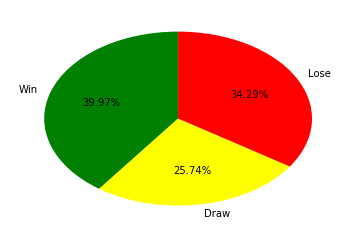

In [30]:
# get favorite team to show result graph
inp = input('Team name : ')
result_plot(inp)